# Datatón BC 2018 - Robocoach (Análisis de la variable descripción)

Se parte generando una base de datos en formato SQL con las tablas suministradas, esta base de datos está en la platafor AZURE de Microsoft y será cargada desde Google Colab por medio de un notebook de Python

La máquina virtual de Google Colab requiere la instalación de los siguientes paquetes para cargar la base de datos SQL 

In [55]:
!apt-get install libqt4-sql-odbc
!apt-get install unixodbc unixodbc-dev --install-suggests
!curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
!curl https://packages.microsoft.com/config/ubuntu/18.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
!apt-get update
!ACCEPT_EULA=Y apt-get install msodbcsql17

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libqt4-sql-odbc is already the newest version (4:4.8.7+dfsg-7ubuntu1).
The following packages were automatically installed and are no longer required:
  autoconf autoconf-archive autoconf-doc automake autopoint gettext
  gettext-base gettext-doc gnu-standards libasprintf-dev libasprintf0v5
  libcroco3 libgettextpo-dev libgettextpo0 libsigsegv2 libtool-doc m4 m4-doc
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unixodbc-dev is already the newest version (2.3.4-1.1ubuntu3).
unixodbc is already the newest version (2.3.4-1.1ubuntu3).
The following packages were automatically installed and are no longer required:
  autoconf autoconf-archive autoconf-doc automake autopoint gettext
  gettext-base gettext-doc gnu-standards libasprintf-dev libasprintf0v

In [56]:
 !pip install pyodbc

Carga de las librerías de Python utilizadas

In [0]:
import numpy as np
import pandas as pd
import pyodbc
import string
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabaz_score
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import download
from scipy.cluster import hierarchy

Verificación de la instalación de pyodbc y del driver para gestionar SQL 

In [58]:
pyodbc.drivers()

['ODBC Driver 17 for SQL Server']

Definición de la conexión con el servidor de la base de datos de entrada

In [0]:
conn = pyodbc.connect("Driver={ODBC Driver 17 for SQL Server};Server=tcp:robocoach.database.windows.net,1433;" \
                      "Database=datathon_database;Uid=datathon_admin@robocoach;Pwd=robocoach.2018;Encrypt=yes;"\
                      "TrustServerCertificate=yes;Connection Timeout=120;encoding='cp1252'")

Carga de la primera vista de los datos, esta se hace con el objetivo de definir las categorías que serán etiquetas de los datos. 
Se cargan las descripciones de todos los datos (transacciones) 

In [0]:
# sql = "SELECT * FROM transacciones_personas_v" # Toda la tabla (no recomendado)
#sql = "SELECT DISTINCT descripcion FROM transacciones_personas_v GROUP BY descripcion"
sql = "SELECT DISTINCT descripcion, COUNT(id_trn_ach) AS num_records FROM transacciones_personas_v GROUP BY descripcion" # se demora 200 segundos

data = pd.read_sql(sql,conn)

#print(data.to_string())

Número total de datos

In [61]:
np.sum(data['num_records'])

11853782

Descarte de los datos que tienen descripción nula

In [62]:
data.dropna(how='any', inplace=True)
#data
np.sum(data['num_records'])

3307385

Crear diccionario para reemplazar caractéres con tildes antes del vectorizer
(http://www.merinomartinez.com/2012/06/tabla-de-conversion-de-simbolos-utf-8-a-iso-8859-1-ansi/)

In [63]:
accents_dict = {
    #"Ã?": "A", 
    "Ã‰":"E", 
    "Ã": "I", 
    "Ã“": "O", 
    "Ãš": "U",
    "Ã¡": "a",
    "Ã³": "o", 
    "Ã©": "e",  
    "Ãº": "u",
    "Ã­": "i",
    "Ã‘": "Ñ",
    "Ã±": "ñ",
}

data.replace(to_replace=accents_dict, inplace=True, regex=True)
data

,subsector,num_records
0,COMERCIO DE VARIEDADES Y VESTUARIO,3603
1,SEGUROS,8357
2,VALOR AGREGADO,548028
3,COMISIONISTAS DE BOLSA,12
4,SERVICIOS A EMPRESAS,45479
5,TRANSPORTE TERRESTRE,5336
6,MUNICIPIOS,95742
7,ESTABLECIMIENTOS EDUCATIVOS,39611
8,TRANSPORTE AEREO,113
9,CEMENTO,2723


Exporta la lista de descripciones únicas a un CSV

In [0]:
#data.to_csv('unique_des.csv')

Descarga las stopwords (lista de palabras que normalmente no describen un texto como artículos, preposiciones, verbos comunes, entre otros)

In [0]:
#df.name.unique()

In [66]:
download('stopwords')
spanish_stop_words = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Función translator para remover todos los signos de puntuacion

In [0]:
translator = str.maketrans('','', string.punctuation)

Para obtener todas las palabras unicas en descripcion, se crea una variable dictionary con todo el texto de descripción 

In [68]:
dictionary = ''.join([descripcion + " " for descripcion in data['descripcion']])
dictionary = dictionary.translate(translator)
dictionary

'COMERCIO DE VARIEDADES Y VESTUARIO SEGUROS VALOR AGREGADO COMISIONISTAS DE BOLSA SERVICIOS A EMPRESAS TRANSPORTE TERRESTRE MUNICIPIOS ESTABLECIMIENTOS EDUCATIVOS TRANSPORTE AEREO CEMENTO BEBIDAS NO ALCOHOLICAS DISTRIBUIDORES PRODUCTOS CONSUMO MASIVO FIDUCIARIAS AUTOMOTORES FERRETERÃA OTROS SERVICIOS FINANCIEROS TEXTILES FONDOS DE PENSIONES OBRAS DE INFRAESTRUCTURA IMPRENTAS Y EDICION OTRAS ACTIVIDADES MINERAS BANCOS SUPERMERCADOS IPS ACUEDUCTO Y ALCANTARILLADO ASEO ADMINISTRACION CENTRAL DEPARTAMENTOS COMERCIO DE FARMACEUTICOS COMERCIO DE ELECTRODOMESTICOS CONSERVAS OTROS MANUFACTURA EPS Y SALUD PREPAGADA SALUD COMBUSTIBLES Y LUBRICANTES PERSONAS ALIMENTOS CONCENTRADOS PRODUCTOS METALICOS COMPANÃAS DE FINANCIAMIENTO COMERCIAL MANUFACTURA DE PRODUCTOS FARMACEUTICOS HOTELES TELEFONIA FIJA ELECTRICIDAD CAJAS DE COMPENSACION ARROZ PRODUCTOS CERAMICOS COMERCIO DE REPUESTOS SERVICIOS A PERSONAS MADERA Y MUEBLES MEDIOS AGROQUIMICOS MANUFACTURA DE PRODUCTOS DE TOCADOR Y ARTICULOS DE ASEO PLAS

Se normalizan las palabras usando stemmer ya que muchas variaciones de una palabra tienen el mismo significado (p.e empresarial, empresariales y empresa se reducen a empres)

In [69]:
stemmer = SnowballStemmer('spanish')
stemmed_dictionary = ''.join([stemmer.stem(w) + " " for w in dictionary.split() if w not in spanish_stop_words])
stemmed_dictionary

'comerci de variedad y vestuari segur valor agreg comision de bols servici a empres transport terrestr municipi establec educ transport aere cement beb no alcohol distribuidor product consum masiv fiduciari automotor ferreterã otros servici financier textil fond de pension obras de infraestructur imprent y edicion otras activ miner banc supermerc ips acueduct y alcantarill ase administracion central departament comerci de farmaceut comerci de electrodomest conserv otros manufactur eps y salud prepag salud combust y lubric person aliment concentr product metal companã de financi comercial manufactur de product farmaceut hotel telefoni fij electr caj de compensacion arroz product ceram comerci de repuest servici a person mader y muebl medi agroquim manufactur de product de tocador y articul de ase plastic edif confeccion '

Se asigna un numero a cada palabra unica y se crea una función de vectorizado TFIDF ( term frequency–inverse document frequency)

In [70]:
vectorizer = TfidfVectorizer()
vectorizer.fit(stemmed_dictionary.split())
vectorizer.vocabulary_

{'activ': 0,
 'acueduct': 1,
 'administracion': 2,
 'aere': 3,
 'agreg': 4,
 'agroquim': 5,
 'alcantarill': 6,
 'alcohol': 7,
 'aliment': 8,
 'arroz': 9,
 'articul': 10,
 'ase': 11,
 'automotor': 12,
 'banc': 13,
 'beb': 14,
 'bols': 15,
 'caj': 16,
 'cement': 17,
 'central': 18,
 'ceram': 19,
 'combust': 20,
 'comerci': 21,
 'comercial': 22,
 'comision': 23,
 'companã': 24,
 'compensacion': 25,
 'concentr': 26,
 'confeccion': 27,
 'conserv': 28,
 'consum': 29,
 'de': 30,
 'departament': 31,
 'distribuidor': 32,
 'edicion': 33,
 'edif': 34,
 'educ': 35,
 'electr': 36,
 'electrodomest': 37,
 'empres': 38,
 'eps': 39,
 'establec': 40,
 'farmaceut': 41,
 'ferreterã': 42,
 'fiduciari': 43,
 'fij': 44,
 'financi': 45,
 'financier': 46,
 'fond': 47,
 'hotel': 48,
 'imprent': 49,
 'infraestructur': 50,
 'ips': 51,
 'lubric': 52,
 'mader': 53,
 'manufactur': 54,
 'masiv': 55,
 'medi': 56,
 'metal': 57,
 'miner': 58,
 'muebl': 59,
 'municipi': 60,
 'no': 61,
 'obras': 62,
 'otras': 63,
 'otros'

Se aplica la reduccion con stemmer a la lista de descripciones una por una

In [0]:
stemmed_descriptions = []
for description in data['subsector']:
  description = description.translate(translator)
  stemmed_descriptions.append(''.join([stemmer.stem(w) + " " for w in description.split() if w not in spanish_stop_words]))

Se crea la matriz de incidencia de las palabras de vectorizer en las descripciones

In [0]:
incidency_matrix = vectorizer.transform(stemmed_descriptions)

Para validar se analiza la primera descripcion (Edicion de periodicos, revistas y otras publicaciones periodicas), de la matriz de incidencia se obtiene la presencia de 4 palabras que son: edicion, period, public y revist

In [73]:
np.argwhere(incidency_matrix[0].toarray() > 0)

array([[ 0, 21],
       [ 0, 30],
       [ 0, 81],
       [ 0, 82]])

In [74]:
cluster_model = AgglomerativeClustering(n_clusters=14)
cluster_model.fit(incidency_matrix.toarray())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=14,
            pooling_func=<function mean at 0x7fba626aa158>)

In [75]:
np.savetxt('labels_clustering.csv', cluster_model.labels_, delimiter=",")
cluster_model.labels_

array([11,  1,  0,  8,  5,  9,  1,  0,  9,  1,  0,  7,  0,  1,  6,  5,  0,
        8,  8,  1,  1,  1,  1,  1,  0,  3,  1,  1, 11, 11,  0,  5,  0,  0,
       13,  6,  7,  8,  3,  1,  2,  0,  8,  0,  7, 11, 13,  2,  0,  4,  3,
       12,  4, 10])

In [76]:
np.unique(cluster_model.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [77]:
cluster_model.n_leaves_

54

In [78]:
cluster_model.n_components_

1

In [79]:
cluster_model.children_.shape

(53, 2)

In [80]:
cluster_model.children_

array([[ 34,  46],
       [ 38,  50],
       [ 28,  29],
       [ 45,  56],
       [  5,   8],
       [ 15,  31],
       [ 36,  44],
       [  0,  57],
       [ 11,  60],
       [  3,  17],
       [ 18,  63],
       [ 42,  64],
       [ 37,  65],
       [  4,  59],
       [ 25,  55],
       [  1,  19],
       [  2,   7],
       [  6,  20],
       [ 10,  70],
       [ 24,  72],
       [  9,  26],
       [ 12,  32],
       [ 16,  33],
       [ 14,  35],
       [ 40,  47],
       [ 21,  22],
       [ 27,  39],
       [ 41,  43],
       [ 48,  81],
       [ 49,  52],
       [ 13,  69],
       [ 79,  84],
       [ 71,  85],
       [ 23,  86],
       [ 80,  87],
       [ 30,  73],
       [ 74,  88],
       [ 82,  89],
       [ 75,  91],
       [ 76,  92],
       [ 77,  83],
       [ 51,  90],
       [ 78,  94],
       [ 53,  93],
       [ 95,  96],
       [ 97,  98],
       [ 66,  68],
       [ 54,  67],
       [ 61, 100],
       [ 58,  99],
       [ 62, 103],
       [101, 104],
       [102,

In [0]:
distance = np.arange(cluster_model.children_.shape[0])
num_observations = np.arange(2, cluster_model.children_.shape[0] + 2)
linkage_matrix = np.column_stack([cluster_model.children_, distance, num_observations]).astype(float)

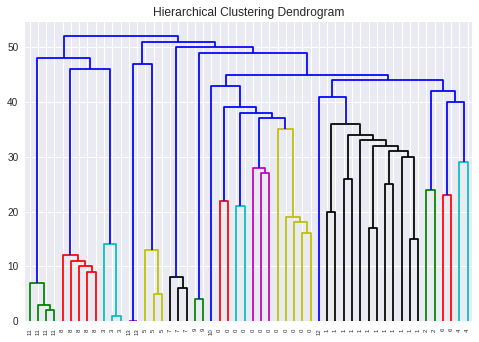

In [82]:
hierarchy.dendrogram(linkage_matrix, labels=cluster_model.labels_)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()


In [0]:
def plot_clustering_metrics(max_clusters, X):
  num_clusters = np.arange(2, max_clusters + 1)
  metrics = []
  for clusters in num_clusters:
    cluster_model = AgglomerativeClustering(n_clusters=clusters)
    cluster_model.fit(X)
    metric = calinski_harabaz_score(X, cluster_model.labels_)
    label = "CB Metric"
    metrics.append(metric)

  fig = plt.figure(figsize=(8,6))
  ax = fig.add_subplot(111)
  ax.plot(num_clusters, metrics, color='blue',
    marker='o', linestyle='-', markersize=5, 
    label=label)
  ax.set_xlabel('Number of clusters')
  ax.set_ylabel('Metric Score')
  ax.set_ylim(np.min(metrics), np.max(metrics))
  ax.grid(linestyle='--')
  ax.legend(loc='lower right')

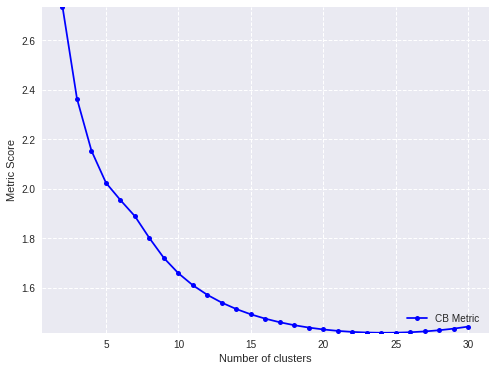

In [84]:
plot_clustering_metrics(30, incidency_matrix.toarray())

In [0]:
from sklearn.decomposition import PCA

In [0]:
incidency_points = PCA(n_components=2).fit_transform(incidency_matrix.toarray())

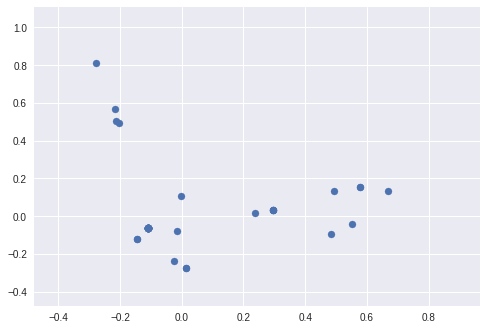

In [87]:
min_point = np.min(incidency_points, axis=0)
max_point = np.max(incidency_points, axis=0)
xmin = min_point[0] - 0.2
ymin = min_point[1] - 0.2
xmax = max_point[0] + 0.3
ymax = max_point[1] + 0.3

# setup marker generator and color map
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
x = []
y = []
for point in incidency_points:
  x.append(point[0])
  y.append(point[1])

plt.scatter(x, y)